In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.5)

**************************************************

Parcel workplace param sweep

**************************************************

Get variables

In [4]:
df = pd.read_pickle('param_sweep.pkl',compression='bz2')
df['NRecovered'] = df['FracRecovered']*df['NStaff']

In [5]:
print(len(df))
TD = np.unique(df["tD"])
Phi = np.unique(df["phi"])
II = np.unique(df["InfInit"])
#parameter reminder
print('Pisol = ', np.unique(df['Pisol']))
print('Random contact rate = ', np.unique(df['p_contact']))
print('Friend contact prob = ', np.unique(df['p_friend_contact']))
print('Staff totals = ', np.unique(df['NStaff']))

In [13]:
dfall = df[df["Group"]=='All']
dfall['outbreak'] = (dfall['NRecovered'] > 4)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'] - 1)
dfall['InfJob'] = np.ones(len(dfall),dtype=np.object)
for i in np.arange(3):
    dfall.loc[dfall['InfInit']==i+1,'InfJob'] = job[i]
dfphi = dfall[(dfall['phi'] == 0.05) | (dfall['phi'] == 0.25) | (dfall['phi'] == 1.0)]

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Index case to outbreak relation

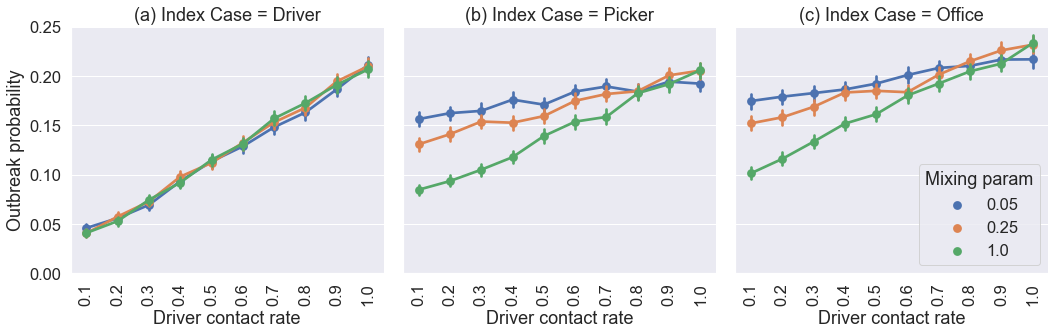

In [15]:
job = ['Driver','Picker','Office']
sp = sns.catplot(x='tD',y='outbreak', hue='phi',col='InfInit',data=dfphi,kind='point',legend=False)
sp.set(xlabel='Driver contact rate',ylim=(0,0.25))
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='lower right',title='Mixing param')
plt.tight_layout()
sp.savefig('param_sweep_outbreak_probability.png')

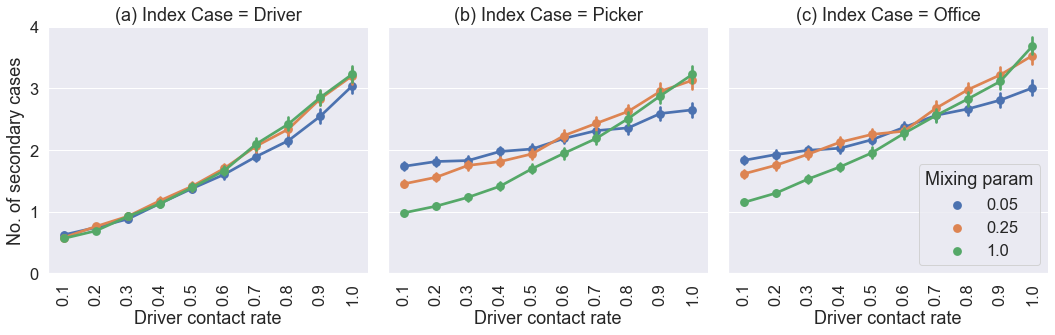

In [27]:
sp = sns.catplot(x='tD',y='Ninfected', hue='phi',col='InfInit',data=dfphi,kind='point',legend=False)
sp.set(ylim=(0,4),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('No. of secondary cases')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='lower right',title='Mixing param')
plt.tight_layout()
sp.savefig('Secondary_infections.png')

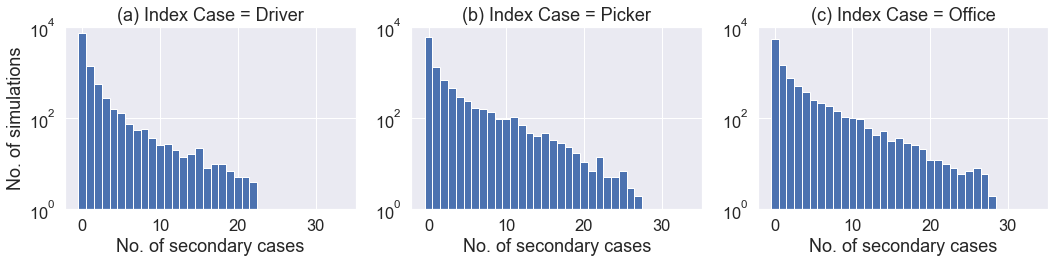

In [46]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ntd = 2
nphi = 0
for (i,II) in enumerate(np.array([1,2,3])):
    dfh = dfall[(dfall['InfInit'] == II)*(dfall['tD']==TD[ntd])*(dfall['phi']==Phi[nphi])]
    ax[i].hist(dfh['Ninfected'],bins=(np.arange(35)-0.5),label='%.2f'%Phi[nphi])
    ax[i].set_yscale('log')
    ax[i].set_ylim((1,10000))
    ax[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
    ax[i].set_xlabel('No. of secondary cases')
ax[0].set_ylabel('No. of simulations')
fig.tight_layout()
fig.savefig('secondary_cases_hist.png')

Count customer infections

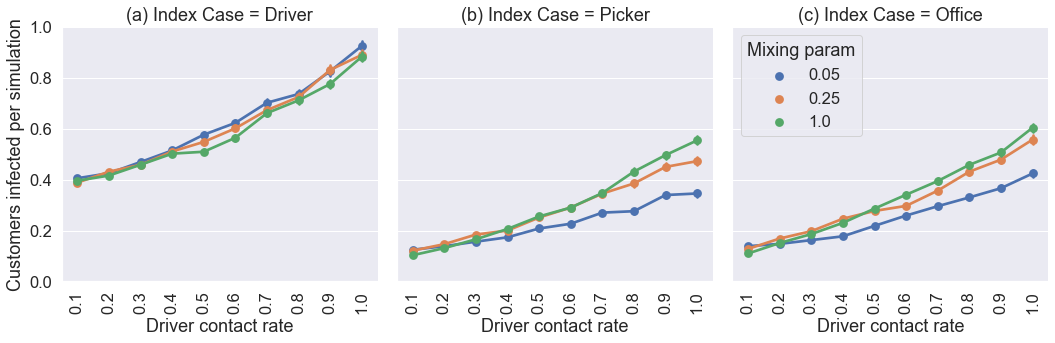

In [17]:
dfh = df[lambda df: (df['phi'] == Phi[0]) | (df['phi'] == Phi[2]) | (df['phi'] == Phi[4])]

sp = sns.catplot(x='tD',y='CustomersInfectedByDrivers',col='InfInit',hue='phi',data=dfh,kind='point',legend=False)
sp.set(ylim=(0,1.0),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('Customers infected per simulation')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
plt.legend(loc='upper left',title='Mixing param')
sp.set_xticklabels(rotation=90)
sp.savefig('Customer_infections.png')

Only weak dependence on phi, and only for small phi. Might be worth showing how NN contacts for each group varies with phi and workplace size

In [18]:
#breakdown of infection causes in the model
jobtypes = np.unique(df['Group'])
print(jobtypes)
netinfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
continfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
roominfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
for (n, g) in enumerate(jobtypes):
    dfg = df.loc[lambda df: (df['Group'] == g)]
    for (i,td) in enumerate(TD):
        dfi =  dfg.loc[lambda dfg: (dfg['tD'] == td)]
        for (j,phi) in enumerate(Phi):
            dfij =  dfi.loc[lambda dfi: (dfi['phi'] == phi)]
            for (k,ii) in enumerate(II):
                dfijk =  dfij.loc[lambda dfij: (dfij['InfInit'] == ii)]
                
                
                netinfs[n,i,j,k] = np.mean(dfijk['NetworkInfectionFrac']*dfijk['NStaff'])
                continfs[n,i,j,k] = np.mean(dfijk['ContactInfectionFrac']*dfijk['NStaff'])
                roominfs[n,i,j,k] = np.mean(dfijk['RoomInfectionFrac']*dfijk['NStaff'])

# for (i,td) in enumerate(TD):
#     for (j,phi) in enumerate(Phi):
#         for (k,ii) in enumerate(II):
#             norm = netinfs[jobtypes=='All',i,j,k][0] + \
#                    continfs[jobtypes=='All',i,j,k][0] + \
#                    roominfs[jobtypes=='All',i,j,k][0]
#             if norm > 0:
#                 for (n, g) in enumerate(jobtypes): 
#                     netinfs[n,i,j,k] /= norm
#                     continfs[n,i,j,k] /= norm
#                     roominfs[n,i,j,k] /= norm

['All' 'Drivers' 'Office' 'Pickers']


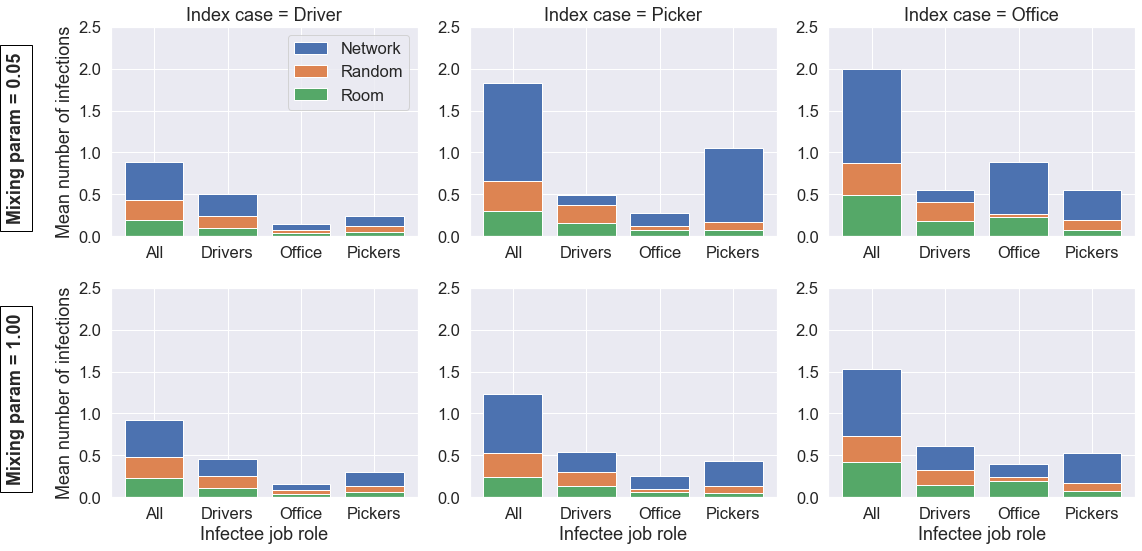

In [19]:
fig,ax = plt.subplots(2,3,figsize=(16,8))                
for k in np.arange(3):
    ax[1,k].bar(jobtypes, netinfs[:,2,len(Phi)-1,k] + \
                          continfs[:,2,len(Phi)-1,k] + \
                          roominfs[:,2,len(Phi)-1,k],label='Network')
    ax[1,k].bar(jobtypes, continfs[:,2,len(Phi)-1,k] + \
                          roominfs[:,2,len(Phi)-1,k],label='Random')
    ax[1,k].bar(jobtypes, roominfs[:,2,len(Phi)-1,k],label='Room')

    ax[0,k].bar(jobtypes, netinfs[:,2,0,k] + continfs[:,2,0,k] + \
                          roominfs[:,2,0,k],label='Network')
    ax[0,k].bar(jobtypes, continfs[:,2,0,k] + roominfs[:,2,0,k],label='Random')
    ax[0,k].bar(jobtypes, roominfs[:,2,0,k],label='Room')
    
    ax[0,k].set_title('Index case = %s'%job[k])
    ax[0,k].set_ylim((0,2.5))
    ax[1,k].set_ylim((0,2.5))
    ax[1,k].set_xlabel('Infectee job role')
ax[0,0].text(-2.0, 0.2, 'Mixing param = %.2f'%Phi[0], rotation='vertical',fontweight='bold',\
            bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                  'edgecolor': 'black'})
ax[1,0].text(-2.0, 0.2, 'Mixing param = %.2f'%Phi[len(Phi)-1], rotation='vertical',fontweight='bold',
             bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                   'edgecolor': 'black'})
ax[0,0].set_ylabel('Mean number of infections')
ax[1,0].set_ylabel('Mean number of infections')
ax[0,0].legend()
fig.tight_layout()
fig.savefig('infection_routes.png')
####need to extract for tD = 0.25, like the rest

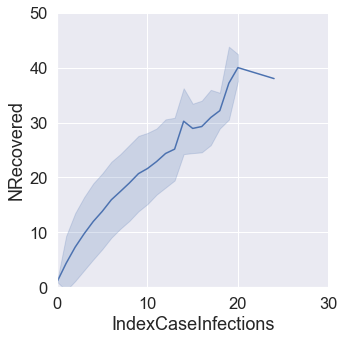

In [20]:
extreme_cases_df = df.loc[lambda df: (df['Group']=='All') & (df['FracRecovered']>10/df['NStaff'])]
#plt.hist(extreme_cases_df['FracRecovered'],bins=20)
figh = sns.relplot(x='IndexCaseInfections',y='NRecovered',data=df.loc[lambda df: (df['Group']=='All')],\
                   kind='line',ci='sd')
figh.set(xlim=(0,30),ylim=(0,50))

In [21]:
job_roles = ['Drivers','Pickers','Office']
phisel = [0.05,1.0]

second_infs_mean = np.zeros((len(job_roles),len(TD),len(phisel),len(II)))
second_infs_std = np.zeros((len(job_roles),len(TD),len(phisel),len(II))) 
for i in np.arange(len(job_roles)):
    dfi = df.loc[lambda df: (df['Group'] == job_roles[i])]
    for j in np.arange(len(TD)):
        dfij = dfi.loc[lambda df: (df['tD'] == TD[j])]
        for k in np.arange(len(phisel)):
            dfijk = dfij.loc[lambda df: (df['phi'] == phisel[k])]
            for n in np.arange(len(II)):
                dfh = dfijk.loc[lambda df: (df['InfInit'] == II[n])]
                if i == n:
                    second_infs_mean[i,j,k,n] = np.mean(dfh['NRecovered']-1)
                    second_infs_std[i,j,k,n] = np.std(dfh['NRecovered']-1)
                else:
                    second_infs_mean[i,j,k,n] = np.mean(dfh['NRecovered'])
                    second_infs_std[i,j,k,n] = np.std(dfh['NRecovered'])

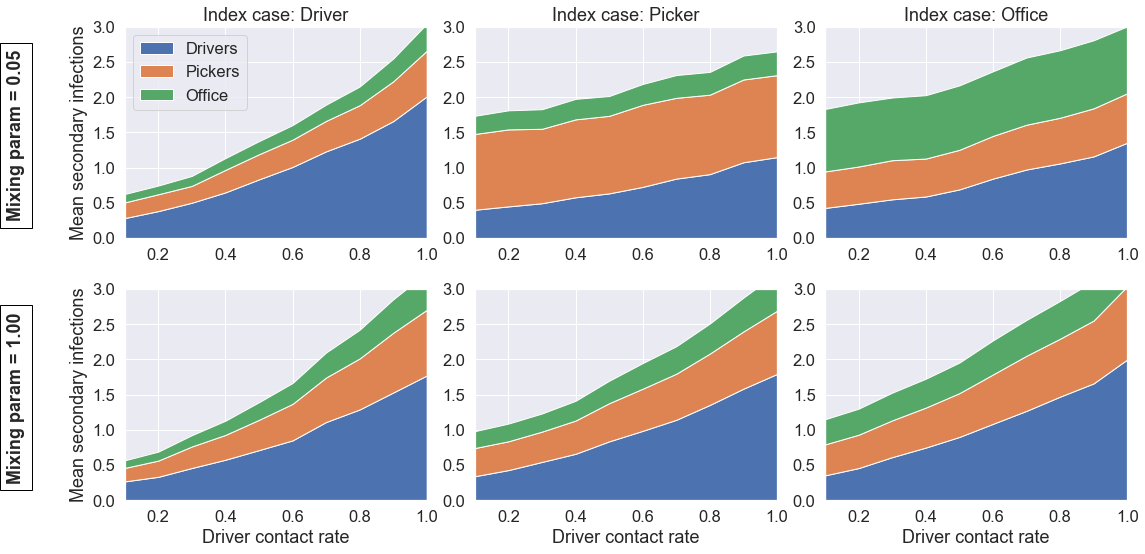

In [22]:
fig, ax = plt.subplots(2,3,figsize=(16,8))

for k in np.arange(len(phisel)):  #row
    for n in np.arange(len(II)):  #col
        ax[k,n].stackplot(TD,[second_infs_mean[0,:,k,n],second_infs_mean[1,:,k,n],\
                                second_infs_mean[2,:,k,n]],labels=job_roles)
        ax[k,n].set_xlim((0.1,1))
        ax[k,n].set_ylim((0,3.0))
        #for i in np.arange(len(job_roles)):
        #ax[k,n].errorbar(TD,np.sum(second_infs_mean[0:i,:,k,n],0),second_infs_std[i,:,k,n])
        ax[1,n].set_xlabel('Driver contact rate')
        ax[0,n].set_title('Index case: %s'%job[n])
    ax[k,0].set_ylabel('Mean secondary infections')
    ax[k,0].text(-0.25, 0.3, 'Mixing param = %.2f'%phisel[k], rotation='vertical',fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                       'edgecolor': 'black'})
ax[0,0].legend(loc='upper left')

fig.tight_layout(pad=1)
fig.savefig('secondary_cases_cumulative.png')

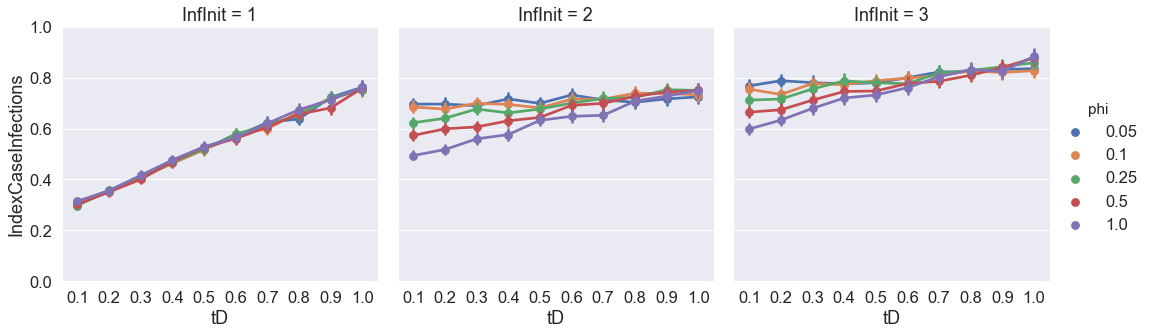

In [23]:
extreme_cases_df = dfall.loc[lambda df: (df['FracRecovered']>10/df['NStaff'])]
#plt.hist(extreme_cases_df['FracRecovered'],bins=20)
figh = sns.catplot(x='tD',y='IndexCaseInfections',col='InfInit',hue='phi',data=dfall,\
                   kind='point')
figh.set(ylim=(0,1))

count customers infected